# GRB MODULE

Roman Le Montagner (IJCLab), Damien Turpin (CEA)

<img src="pres_image/Fink_logo.png" style="width:400px" align="left">
<img src="pres_image/ijclab_logo.png" style="width:400px" align="left">
<img src="pres_image/cnrs_logo.png" style="width:200px" align="left">

## Goal

Find the optical counterparts in the ZTF alerts associated with a Gamma Ray Burst (GRB) with Fink

In [1]:
# Let's find the optical counterparts in the alerts coming for a particular day
from datetime import datetime

current_day = datetime.fromisoformat("2021-02-06")

## Load GCN (Gamma notices) for a given space monitor

Available monitor :
* Fermi
* Swift
* (in a possible post-pandemic futur in China) SVOM

<img src="pres_image/time_window.jpg">

In [2]:
from grb_catalog import get_notice

monitor = "fermi"
gcn = get_notice(monitor)
gcn

,TrigNum,date,time_ut,gm_ra,gm_dec,gm_error
0,674653979,22/05/19,11:52:54.38,54.867,-45.683,28.80
1,674647608,22/05/19,10:06:43.10,52.900,24.883,4.38
2,674647608,22/05/19,10:06:43.10,57.550,22.567,5.60
3,674647608,22/05/19,10:06:43.10,50.567,19.517,6.03
4,674647608,22/05/19,10:06:43.10,57.367,22.167,26.65
...,...,...,...,...,...,...
7938,504931642,17/01/01,02:47:17.87,70.640,-1.580,1.20
7939,504931642,17/01/01,02:47:17.87,59.167,9.333,5.32
7940,504931642,17/01/01,02:47:17.87,70.760,2.330,3.23
7941,504931642,17/01/01,02:47:17.87,59.267,9.100,6.58


## Filtering the GCN

In [3]:
from grb_catalog import grb_filter

time_window = 5 # in days
grb_error_limit = 10 # in degrees
 
gcn = grb_filter(gcn, monitor, current_day, time_window, grb_error_limit)
gcn

,TrigNum,date,time_ut,gm_ra,gm_dec,gm_error,Trig Time
1,634156744,21/02/04,18:38:59.57,272.49,-54.81,2.39,2021-02-04 18:38:59.570
4,634112970,21/02/04,06:29:25.66,116.12,12.70,1.32,2021-02-04 06:29:25.660
12,633989436,21/02/02,20:10:31.30,232.23,-40.40,1.67,2021-02-02 20:10:31.300
18,633963272,21/02/02,12:54:27.00,297.06,18.74,2.80,2021-02-02 12:54:27.000
20,633879387,21/02/01,13:36:22.49,144.98,-50.67,5.07,2021-02-01 13:36:22.490


## Load ZTF alerts with Fink 

In [4]:
import json

path_to_catalog = "hbase_catalogs/ztf_season1.class.json"
path_to_catalog = (
    "/home/julien.peloton/fink-broker/ipynb/hbase_catalogs/ztf_season1.class.json"
) 

with open(path_to_catalog) as f:
    catalog = json.load(f)

df = (
    spark.read.option("catalog", catalog)
    .format("org.apache.hadoop.hbase.spark")
    .option("hbase.spark.use.hbasecontext", False)
    .option("hbase.spark.pushdown.columnfilter", True)
    .load()
    .repartition(500)
)

 ### Request specific Fink class

In [5]:
from fink_utils.xmatch.simbad import return_list_of_eg_host

request_class = return_list_of_eg_host() + [
    "Ambiguous",
    "Solar System candidate",
    "SN candidate",
]

### Get the alerts from the last observation night

In [6]:
from astropy.time import Time, TimeDelta

current_day_jd = Time(current_day, scale="utc").jd

# test_day - 36 hours
yesterday = current_day_jd - TimeDelta(3600 * 36, format="sec").jd

In [7]:
class_pdf = []

for _class in request_class:
    class_pdf.append(
        df.filter(
            df["class_jd_objectId"] >= "{}_{}".format(_class, yesterday)
        ).filter(df["class_jd_objectId"] < "{}_{}".format(_class, current_day_jd))
    )

### Send gcn to all executors 

In [8]:
# send the grb data to the executors
grb_bc = spark.sparkContext.broadcast(gcn)

### Call the association function

In [9]:
from processor import grb_associations

grb_result = []
for alert_class in class_pdf:
    
    p_grb = alert_class.withColumn(
        "grb_score",  
        grb_associations(
            alert_class.ra,
            alert_class.dec,
            alert_class.jd,
            alert_class.jdstarthist,
            alert_class.objectId,
            grb_bc,
            monitor,
            current_day,
            time_window,
        ),
    )

### Using a dedicated function

In [10]:
from processor import detect_grb_counterparts
import time

t_before = time.time()
cross_match = detect_grb_counterparts(
    get_notice("fermi"),
    "fermi",
    current_day,
    time_window
)
print("{} alerts processed in {:.3f} sec".format(len(cross_match), (time.time() - t_before)))

192599 alerts processed in 104.221 sec


In [11]:
from collections import Counter


Counter(cross_match["tags"])

Counter({'Start variation time not in the GRB time window': 190154,
         'Not in any GRB error box': 2407,
         'fast-transient-based-cross-match': 37,
         'proba-based-cross-match': 1})

# Looking the results

In [12]:
ft_objId = cross_match[cross_match["tags"] == "fast-transient-based-cross-match"]

proba_objId = cross_match[cross_match["tags"] == "proba-based-cross-match"]

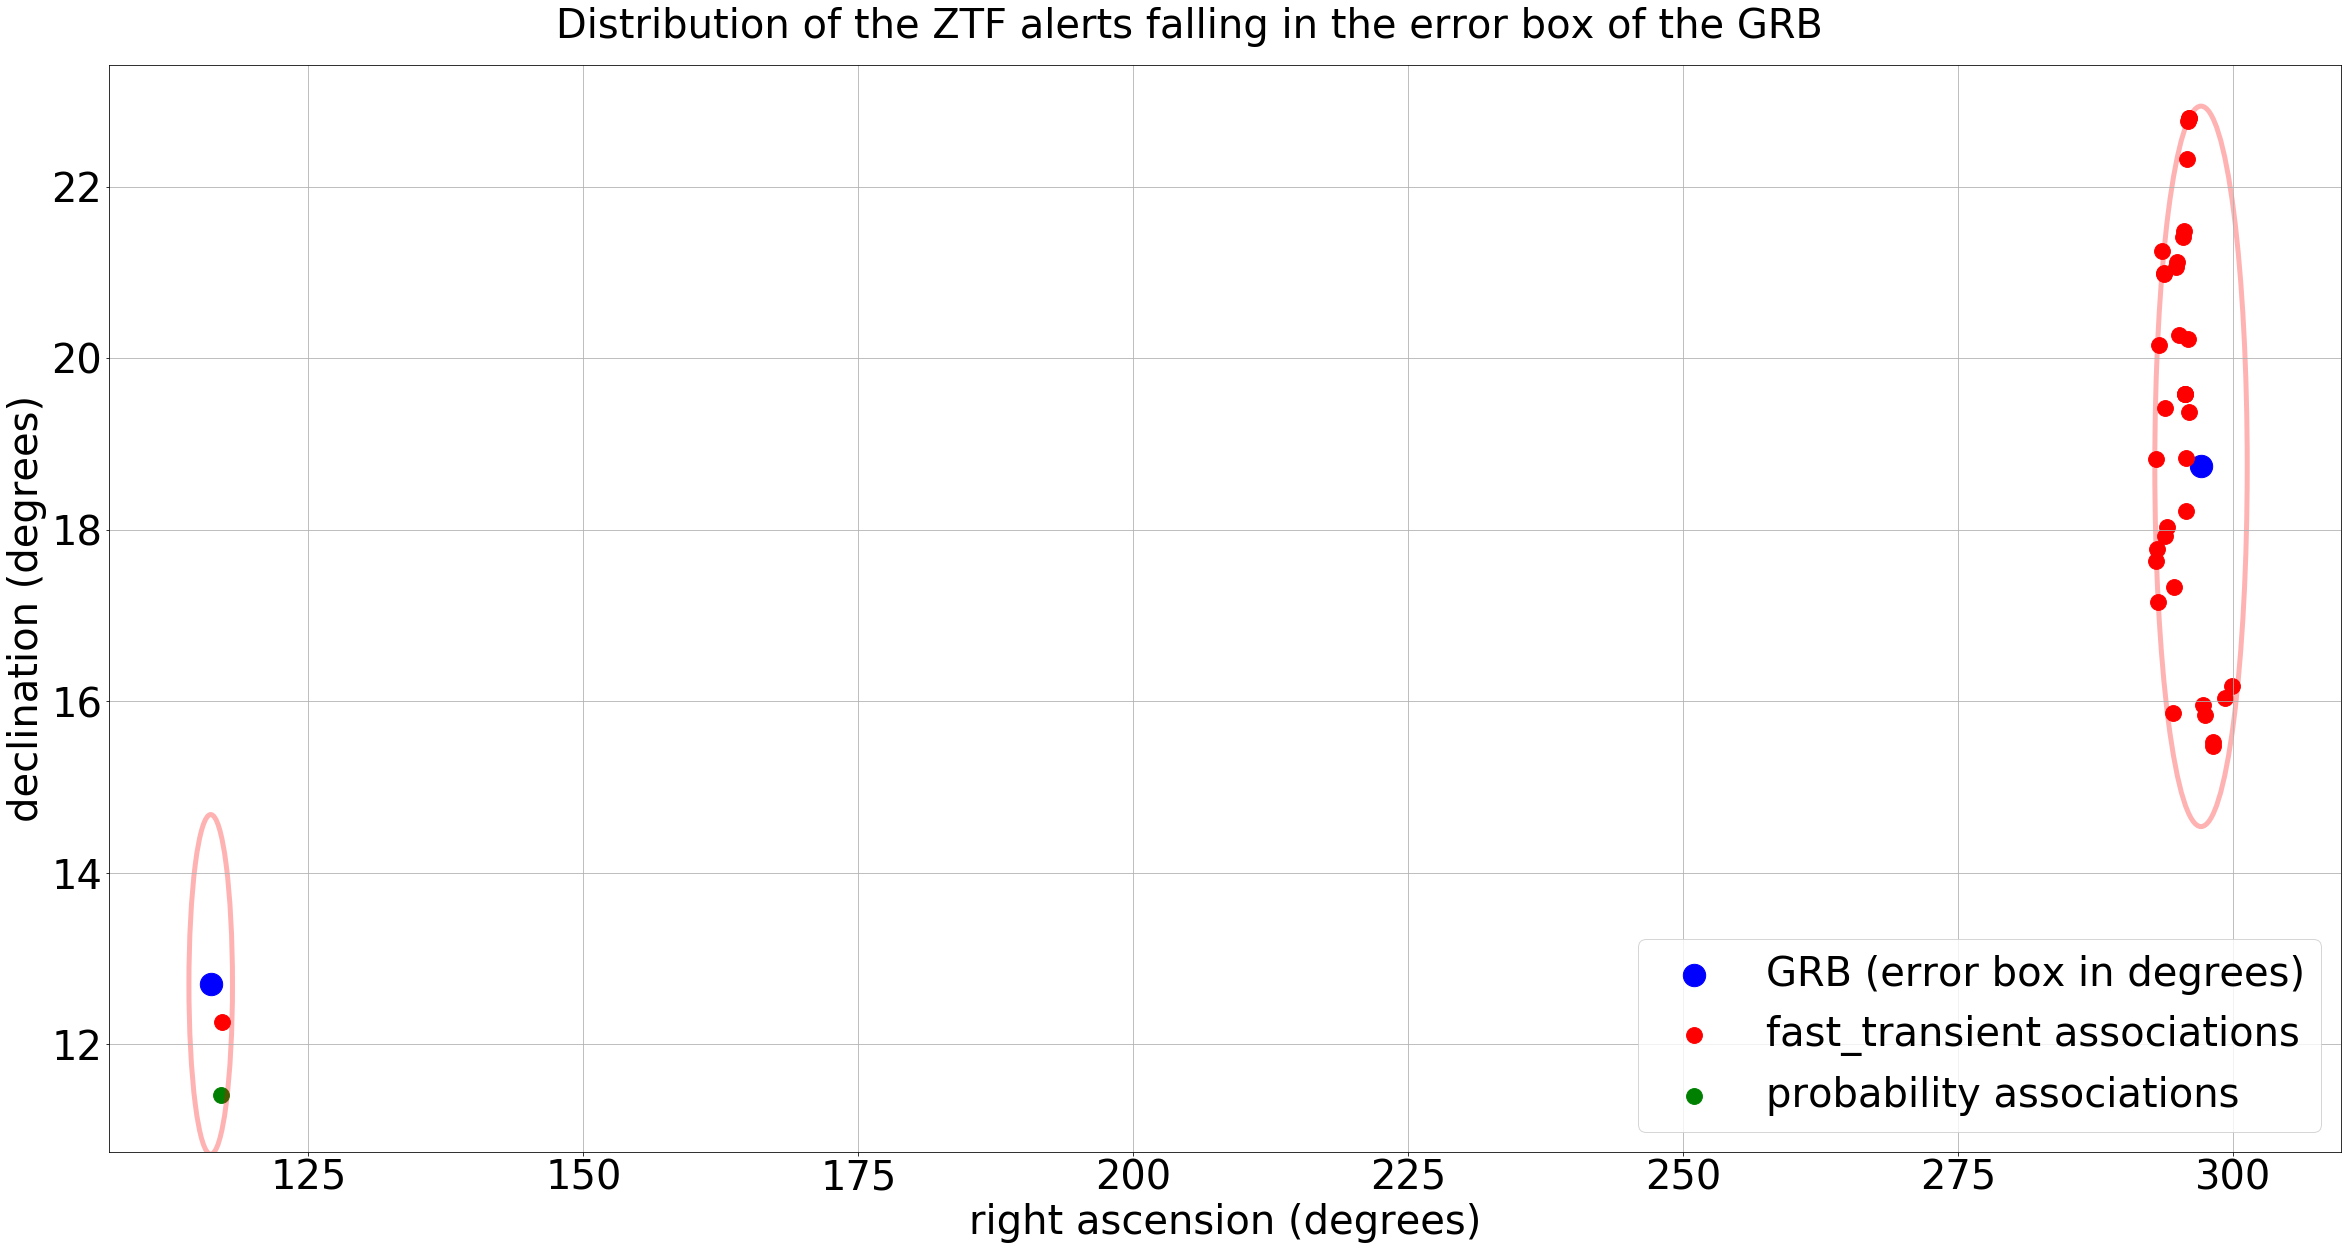

In [13]:
from plots import plot_grb_dist

plot_grb_dist(gcn, ft_objId, proba_objId)

### Inspect the light curves of the candidates

In [14]:
import requests
import pandas as pd
import numpy as np
from fink_utils.photometry.conversion import dc_mag

In [17]:
x_str = ",".join(ft_objId["objectId"])

r = requests.post(
    "https://fink-portal.org/api/v1/objects",
    json={
        "objectId": x_str,
        "output-format": "json",
        "withupperlim": True,
        "withcutouts": False,
    },
)

# Format output in a DataFrame
ft_cand_pdf = pd.read_json(r.content)[[
    "i:objectId", 
    "i:jd", 
    "i:jdstarthist", 
    "i:fid", 
    "i:magpsf",
    "i:sigmapsf",
    "i:magnr",
    "i:sigmagnr",
    "i:magzpsci",
    "i:isdiffpos",
    "i:diffmaglim",
    "v:classification",
    "d:tag"
]]

In [18]:
# Compute the apparent magnitude

dc_mag_res = np.array(ft_cand_pdf.apply(lambda x: dc_mag(x[3], x[4], x[5], x[6], x[7], x[8], x[9]), axis=1, result_type="expand").rename({
    0: "dcmag",
    1: "dcmag_err"
}, axis=1).values)

ft_cand_pdf.insert(len(ft_cand_pdf.columns), "dcmag", dc_mag_res[:, 0])
ft_cand_pdf.insert(len(ft_cand_pdf.columns), "dcmag_err", dc_mag_res[:, 1])

In [19]:
def grb_delay(x):
    jd = x["i:jd"]
    
    jdstarthist = x["i:jdstarthist"]
    
    obj_id = x["i:objectId"]
    ft_assoc = ft_objId[ft_objId["objectId"] == obj_id]
    grb_jd = Time(gcn[gcn["TrigNum"] == ft_assoc["GRB_trignum"].values[0][0]]["Trig Time"]).jd
    return (jd - grb_jd)[0] * 3600 * 24

ft_cand_pdf["delay"] = ft_cand_pdf.apply(grb_delay, axis=1)

In [20]:
pdf_grb = pd.read_json("transient_data.json")
print("Credits : GRBase project, Damien Turpin et al.")

Credits : GRBase project, Damien Turpin et al.


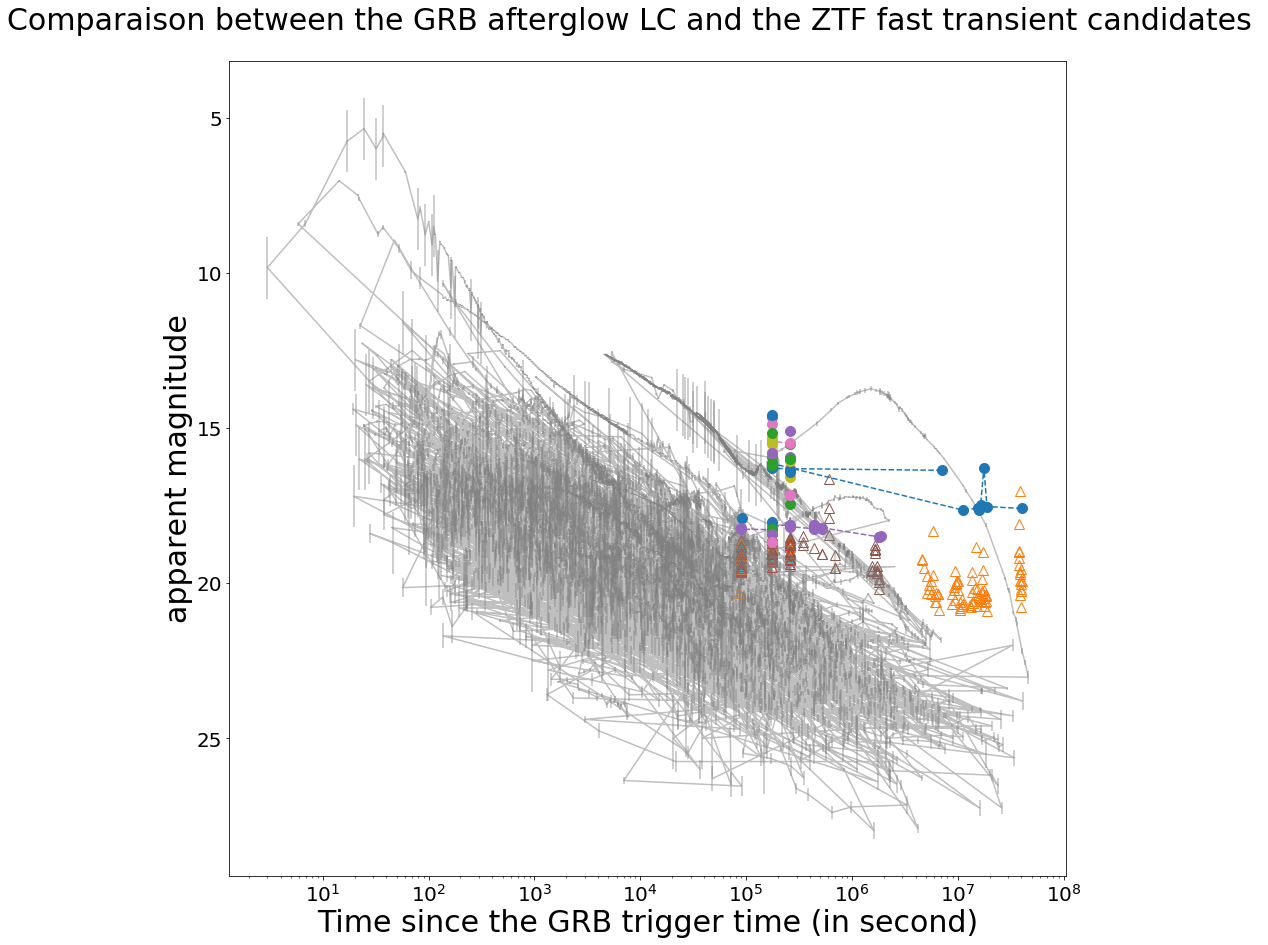

In [21]:
from plots import grb_ft_plot

grb_ft_plot(pdf_grb, ft_cand_pdf)

### Observe the light curve of the candidate return by probability

#### Request the full data for this object

In [22]:
import requests
from utilities import request_fink
import pandas as pd

r = requests.post(
    "https://fink-portal.org/api/v1/objects",
    json={
        "objectId": proba_objId["objectId"].values[0],
        "output-format": "json",
        "withupperlim": True,
        "withcutouts": False,
        "columns": "i:objectId,i:fid,i:jd,i:magpsf,i:sigmapsf,i:magnr,i:sigmagnr,i:magzpsci,i:isdiffpos,i:diffmaglim",
    },
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)
pdf

,i:diffmaglim,i:fid,i:isdiffpos,i:jd,i:magnr,i:magpsf,i:magzpsci,i:objectId,i:sigmagnr,i:sigmapsf,d:tag
0,20.613667,2,t,2.459253e+06,21.835,20.561028,26.267027,ZTF21aagwbjr,0.111,0.214267,valid
1,20.237915,2,t,2.459251e+06,21.835,19.351044,26.283043,ZTF21aagwbjr,0.111,0.105226,valid
2,20.394405,1,t,2.459251e+06,22.819,19.614769,26.306768,ZTF21aagwbjr,0.358,0.145175,valid
3,20.735400,1,None,2.459249e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
4,20.352000,2,None,2.459249e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
5,20.588000,2,None,2.459233e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
6,20.766600,1,None,2.459233e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
7,20.573400,1,None,2.459231e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
8,20.471000,2,None,2.459231e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim
9,20.597100,1,None,2.459229e+06,NaN,NaN,NaN,ZTF21aagwbjr,NaN,NaN,upperlim


#### Compute the apparent magnitude

In [23]:
dc_mag_res = np.array(pdf.apply(lambda x: dc_mag(x[1], x[5], x[-2], x[4], x[-3], x[6], x[2]), axis=1, result_type="expand").rename({
    0: "dcmag",
    1: "dcmag_err"
}, axis=1).values)

pdf.insert(len(pdf.columns), "dcmag", dc_mag_res[:, 0])
pdf.insert(len(pdf.columns), "dcmag_err", dc_mag_res[:, 1])

#### Get the informations of the associated GRB

In [24]:
grb_with_cand_counterparts = gcn[gcn["TrigNum"] == proba_objId["GRB_trignum"].values[0][0]] # associated GRB
grb_jd = Time(grb_with_cand_counterparts["Trig Time"].values[0]).jd # trigger time
grb_trignum = grb_with_cand_counterparts["TrigNum"].values[0] # GRB trigger time

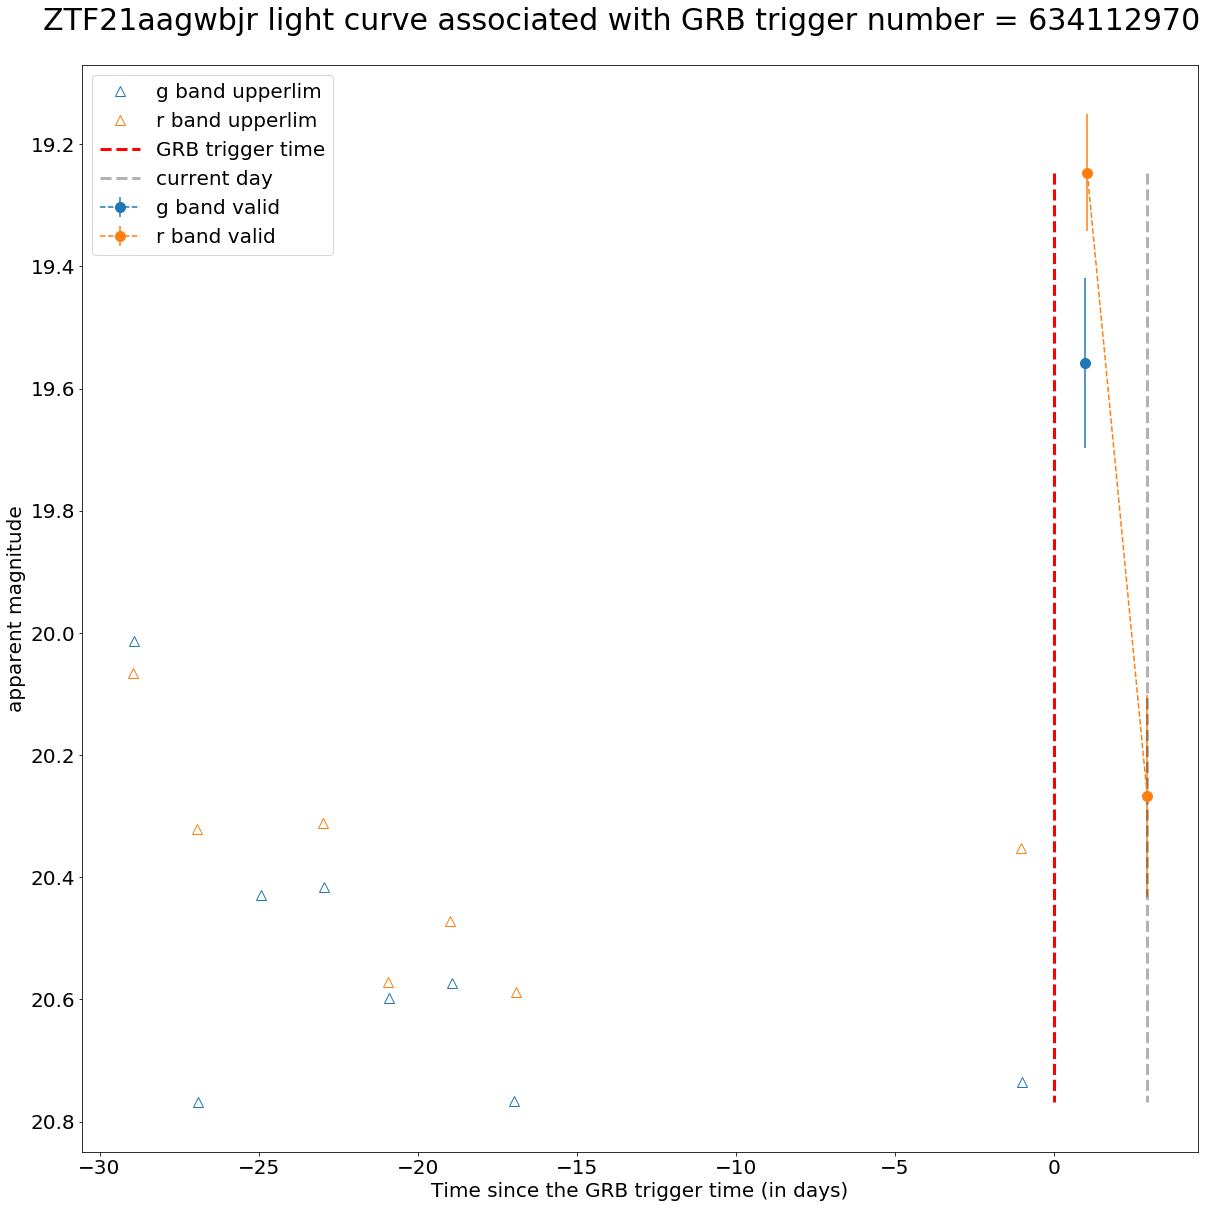

In [25]:
from plots import plot_grb_candidates

plot_grb_candidates(pdf, grb_jd, grb_trignum)

### GRB trigger number 634112970 == GRB210204A

* ZTF21aagwbjr is the afterglow associated with GRB210204A 
    * (Reporter/s : Erik Kool, Igor Andreoni, Anna Ho, Michael Coughlin, Tomas Ahumada, Daniel Perley, Yuhan Yao)
* The long-active afterglow of GRB 210204A: Detection of the most delayed flares in a Gamma-Ray Burst
    * harsh kumar et al, 15 april 2022

# Perspective

* Optimization
* Send GRB afterglow candidate to the users
* Scoring system for the fast transient
* Build a new module to follow the GRB candidates and find the associated supernovae.
* Add the GRB panels to the science portal.

# Thank you for your attention